In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
"""
This script provides a robust, advanced implementation of the approach described
in the paper "Empowering Few-Shot Recommender Systems With Large Language
Models-Enhanced Representations".

This version includes a full experimental pipeline with dynamic run management,
checkpointing, resuming, plotting, and comprehensive, separated result saving.

This version includes:
1.  **Dynamic Experiment Management**: Automatically creates a unique folder for
    each run based on hyperparameters, allowing for easy comparison of different
    experimental setups without overwriting results.
2.  **Separated Result Files**: Saves results for the recommendation and
    interaction prediction tasks into separate, clearly named files.
3.  **Checkpointing & Resuming**: Saves model and optimizer state after each
    epoch. Automatically resumes training if the script is interrupted.
4.  **Paper-Aligned Data Processing**: Implements the "leave-two-out" strategy.
5.  **Paper-Aligned Models**: Implements BPR-MF and NCF baselines.
6.  **BERT for Enhanced Embeddings**: Uses a powerful local LLM (BERT).
7.  **Projection Layers**: Uses trainable projection layers to adapt embeddings.
8.  **Shared Caching**: Caches the dataset and embeddings in a parent directory
    to be shared across all experimental runs, saving time.
"""

'\nThis script provides a robust, advanced implementation of the approach described\nin the paper "Empowering Few-Shot Recommender Systems With Large Language\nModels-Enhanced Representations".\n\nThis version includes a full experimental pipeline with dynamic run management,\ncheckpointing, resuming, plotting, and comprehensive, separated result saving.\n\nThis version includes:\n1.  **Dynamic Experiment Management**: Automatically creates a unique folder for\n    each run based on hyperparameters, allowing for easy comparison of different\n    experimental setups without overwriting results.\n2.  **Separated Result Files**: Saves results for the recommendation and\n    interaction prediction tasks into separate, clearly named files.\n3.  **Checkpointing & Resuming**: Saves model and optimizer state after each\n    epoch. Automatically resumes training if the script is interrupted.\n4.  **Paper-Aligned Data Processing**: Implements the "leave-two-out" strategy.\n5.  **Paper-Aligned Mo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from tqdm import tqdm
import os
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
import json
import datetime


In [ ]:
# --- Setup and Configuration ---

# 1. Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
except (ImportError, ModuleNotFoundError):
    print("Could not import Google Drive module. Running locally.")
    DRIVE_MOUNTED = False

# 2. Hyperparameters and Global Configuration
SBERT_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
LLM_MODEL_NAME = 'bert-base-uncased'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 150
LEARNING_RATE = 0.001
BATCH_SIZE = 256
K_METRICS = 10
PROJECTION_DIM = 128
NUM_USERS_TO_SAMPLE = 2000
MAX_REVIEWS_PER_USER = 10

# --- Dynamic Path Generation for Experiments ---
def get_experiment_paths():
    """Generates a unique path for the current experimental run."""
    run_name = (
        f"run_llm-{LLM_MODEL_NAME.replace('/', '_')}_"
        f"pdim{PROJECTION_DIM}_lr{LEARNING_RATE}_e{EPOCHS}_"
        f"k{K_METRICS}_u{NUM_USERS_TO_SAMPLE}_rev{MAX_REVIEWS_PER_USER}_b{BATCH_SIZE}"
    )

    drive_base_path = '/content/drive/MyDrive/' if DRIVE_MOUNTED else './'
    parent_exp_path = os.path.join(drive_base_path, 'LLM_RecSys_Experiments_Parent')
    experiment_path = os.path.join(parent_exp_path, run_name)

    os.makedirs(parent_exp_path, exist_ok=True)
    os.makedirs(experiment_path, exist_ok=True)
    os.makedirs(os.path.join(experiment_path, 'checkpoints'), exist_ok=True)

    paths = {
        "parent": parent_exp_path,
        "run": experiment_path,
        "checkpoints": os.path.join(experiment_path, 'checkpoints'),
        "real_dataset": os.path.join(drive_base_path, 'Datasets/Movies_and_TV_5.json'),
        # --- DYNAMIC FILE NAMING ---
        "sampled_dataset": os.path.join(parent_exp_path, f'sampled_{NUM_USERS_TO_SAMPLE}_user_dataset.csv'),
        "bert_cache": os.path.join(parent_exp_path, f'bert_embeddings_{LLM_MODEL_NAME.replace("/", "_")}_{NUM_USERS_TO_SAMPLE}_users_cache.json'),
        # --- END DYNAMIC FILE NAMING ---
        "log": os.path.join(experiment_path, 'experiment_log.log'),
        "history_rec": os.path.join(experiment_path, 'history_recommendation.xlsx'),
        "history_pred": os.path.join(experiment_path, 'history_interaction_prediction.xlsx'),
        "final_rec": os.path.join(experiment_path, 'final_results_recommendation.xlsx'),
        "final_pred": os.path.join(experiment_path, 'final_results_interaction_prediction.xlsx'),
        "plot_rec": os.path.join(experiment_path, 'learning_curves_recommendation.png'),
        "plot_pred": os.path.join(experiment_path, 'learning_curves_interaction.png')
    }
    return paths

PATHS = get_experiment_paths()

# 3. Setup Logging
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s',
                    handlers=[logging.FileHandler(PATHS['log'], mode='w'), logging.StreamHandler()])

logging.info(f"Using device: {DEVICE}")
logging.info(f"Starting experiment run. Results will be saved in: {PATHS['run']}")
logging.info(f"Experiment paths: {PATHS}")

2025-07-09 19:25:39,343 [INFO] - Using device: cuda
2025-07-09 19:25:39,345 [INFO] - Starting experiment run. Results will be saved in: /content/drive/MyDrive/LLM_RecSys_Experiments_Parent/run_llm-bert-base-uncased_pdim128_lr0.001_e150_k10_u2000_rev10_b256
2025-07-09 19:25:39,346 [INFO] - Experiment paths: {'parent': '/content/drive/MyDrive/LLM_RecSys_Experiments_Parent', 'run': '/content/drive/MyDrive/LLM_RecSys_Experiments_Parent/run_llm-bert-base-uncased_pdim128_lr0.001_e150_k10_u2000_rev10_b256', 'checkpoints': '/content/drive/MyDrive/LLM_RecSys_Experiments_Parent/run_llm-bert-base-uncased_pdim128_lr0.001_e150_k10_u2000_rev10_b256/checkpoints', 'real_dataset': '/content/drive/MyDrive/Datasets/Movies_and_TV_5.json', 'sampled_dataset': '/content/drive/MyDrive/LLM_RecSys_Experiments_Parent/sampled_2000_user_dataset.csv', 'bert_cache': '/content/drive/MyDrive/LLM_RecSys_Experiments_Parent/bert_embeddings_bert-base-uncased_2000_users_cache.json', 'log': '/content/drive/MyDrive/LLM_RecSy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1. Data Loading and Preparation ---
def load_and_prepare_dataset_leave_two_out(original_path, sampled_path, num_users_sample, max_reviews_train):
    if os.path.exists(sampled_path):
        logging.info(f"Loading pre-sampled dataset from {sampled_path}")
        df_sampled = pd.read_csv(sampled_path)
    else:
        logging.info("No pre-sampled dataset found. Creating one now...")
        if not os.path.exists(original_path):
            logging.error(f"Original dataset not found at path: {original_path}"); return None, None, None
        data = [json.loads(line) for line in open(original_path, 'r')]
        full_df = pd.DataFrame(data)
        full_df = full_df.rename(columns={'reviewerID': 'user_id', 'asin': 'item_id', 'reviewText': 'review', 'unixReviewTime': 'timestamp'})
        full_df = full_df[['user_id', 'item_id', 'review', 'timestamp']]
        logging.info(f"Loaded {len(full_df)} total interactions.")

        all_user_ids = pd.unique(full_df['user_id'])
        sampled_user_ids = np.random.choice(all_user_ids, min(len(all_user_ids), num_users_sample), replace=False)
        df_sampled = full_df[full_df['user_id'].isin(sampled_user_ids)]
        df_sampled.to_csv(sampled_path, index=False)
        logging.info(f"Sampled {len(sampled_user_ids)} users and saved to {sampled_path}")

    train_list, val_list, test_list = [], [], []
    df_sampled = df_sampled.sort_values(by=['user_id', 'timestamp'])
    for _, group in tqdm(df_sampled.groupby('user_id'), desc="Splitting data per user (leave-two-out)"):
        if len(group) < 3: continue
        test_list.append(group.iloc[-1].to_dict())
        val_list.append(group.iloc[-2].to_dict())
        train_samples = group.iloc[:-2]
        if len(train_samples) > max_reviews_train:
            train_samples = train_samples.sample(n=max_reviews_train, random_state=42)
        train_list.extend(train_samples.to_dict('records'))

    train_df, val_df, test_df = pd.DataFrame(train_list), pd.DataFrame(val_list), pd.DataFrame(test_list)
    logging.info(f"Final sizes | Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
    return train_df, val_df, test_df

# --- 2. Representation Generation (BERT) ---
class BertEmbeddingGenerator:
    def __init__(self, model_name, device):
        from transformers import BertTokenizer, BertModel
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name).to(device)
        self.device = device
        logging.info(f"Initialized BERT Embedding Generator with model: {model_name}")

    def get_embedding(self, text):
        self.model.eval()
        with torch.no_grad():
            inputs = self.tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(self.device)
            outputs = self.model(**inputs)
            return outputs.last_hidden_state[:, 0, :].squeeze().cpu()

# --- 3. Models ---
class NCF(nn.Module):
    def __init__(self, num_users, num_items, user_embeds, item_embeds, projection_dim):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding.from_pretrained(user_embeds.to(DEVICE), freeze=True)
        self.item_embedding = nn.Embedding.from_pretrained(item_embeds.to(DEVICE), freeze=True)
        self.user_projection = nn.Linear(user_embeds.shape[1], projection_dim)
        self.item_projection = nn.Linear(item_embeds.shape[1], projection_dim)
        self.mlp = nn.Sequential(nn.Linear(projection_dim * 2, 128), nn.ReLU(), nn.Dropout(0.3),
                                 nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1))

    def forward(self, user_indices, item_indices):
        user_embedded, item_embedded = self.user_embedding(user_indices), self.item_embedding(item_indices)
        user_projected, item_projected = self.user_projection(user_embedded), self.item_projection(item_embedded)
        x = torch.cat([user_projected, item_projected], dim=-1)
        return torch.sigmoid(self.mlp(x)).squeeze()

class BPRMF(nn.Module):
    def __init__(self, num_users, num_items, user_embeds, item_embeds, projection_dim):
        super(BPRMF, self).__init__()
        self.user_embedding = nn.Embedding.from_pretrained(user_embeds.to(DEVICE), freeze=True)
        self.item_embedding = nn.Embedding.from_pretrained(item_embeds.to(DEVICE), freeze=True)
        self.user_projection = nn.Linear(user_embeds.shape[1], projection_dim)
        self.item_projection = nn.Linear(item_embeds.shape[1], projection_dim)

    def forward(self, u, i, j):
        user_vec, item_i_vec, item_j_vec = self.user_projection(self.user_embedding(u)), self.item_projection(self.item_embedding(i)), self.item_projection(self.item_embedding(j))
        return (user_vec * item_i_vec).sum(dim=1) - (user_vec * item_j_vec).sum(dim=1)

    def predict(self, u, i):
        user_vec, item_vec = self.user_projection(self.user_embedding(u)), self.item_projection(self.item_embedding(i))
        return (user_vec * item_vec).sum(dim=1)

class InteractionPredictorMLP(NCF):
    pass

# --- 4. Evaluation Functions ---
def evaluate_recommendation(model, dataloader, device, k):
    if dataloader is None: return 0.0, 0.0, 0.0
    model.eval()
    hits, ndcgs, mrrs = [], [], []
    with torch.no_grad():
        for users, items_true, _ in dataloader:
            users, items_true = users.to(device), items_true.to(device)
            all_item_ids = torch.arange(model.item_embedding.num_embeddings).to(device)
            for i in range(len(users)):
                user_id, item_id_true = users[i].unsqueeze(0), items_true[i].item()
                user_tensor = user_id.repeat(len(all_item_ids))
                predictions = model.predict(user_tensor, all_item_ids) if isinstance(model, BPRMF) else model(user_tensor, all_item_ids)
                _, top_k_indices = torch.topk(predictions, k)
                top_k_item_ids = top_k_indices.cpu().numpy().tolist()
                is_hit = item_id_true in top_k_item_ids
                hits.append(1 if is_hit else 0)
                if is_hit:
                    rank = top_k_item_ids.index(item_id_true) + 1
                    ndcgs.append(1 / np.log2(rank + 1)); mrrs.append(1 / rank)
                else:
                    ndcgs.append(0); mrrs.append(0)
    return float(np.mean(hits)), float(np.mean(ndcgs)), float(np.mean(mrrs))

def evaluate_interaction_prediction(model, dataloader, device):
    if dataloader is None: return 0.0, 0.0, 0.0
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for users, items, labels in dataloader:
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            preds = model(users, items)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().round().numpy())
    acc = float(accuracy_score(all_labels, all_preds))
    pre = float(precision_score(all_labels, all_preds, zero_division=0))
    f1 = float(f1_score(all_labels, all_preds, zero_division=0))
    return acc, pre, f1

# --- 5. Training Pipeline with Checkpointing ---
def run_training_pipeline(model, optimizer, loader, val_loader, model_name, embed_type):
    checkpoint_path = os.path.join(PATHS['checkpoints'], f"{model_name}_{embed_type}_checkpoint.pth")
    start_epoch = 0
    history = []

    if os.path.exists(checkpoint_path):
        logging.info(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        history = checkpoint.get('history', [])
        logging.info(f"Resuming from epoch {start_epoch + 1}")

    if start_epoch >= EPOCHS:
        logging.info(f"Model already trained for {start_epoch} epochs. Skipping training.")
        return model, history

    for epoch in range(start_epoch, EPOCHS):
        model.train(); total_loss = 0
        is_bpr = isinstance(model, BPRMF)
        desc = f"{model_name} ({embed_type}) | Epoch {epoch+1}/{EPOCHS}"
        for batch in tqdm(loader, desc=desc):
            batch = [t.to(DEVICE) for t in batch]; optimizer.zero_grad()

            if is_bpr:
                prediction = model(batch[0], batch[1], batch[2])
                loss = -torch.log(torch.sigmoid(prediction)).mean()
            else:
                prediction = model(batch[0], batch[1])
                loss = nn.BCELoss()(prediction, batch[2])

            loss.backward(); optimizer.step(); total_loss += loss.item()

        avg_loss = total_loss / len(loader) if len(loader) > 0 else 0

        if isinstance(model, InteractionPredictorMLP):
            val_acc, val_pre, val_f1 = evaluate_interaction_prediction(model, val_loader, DEVICE)
            logging.info(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Val Pre: {val_pre:.4f} | Val F1: {val_f1:.4f}")
            history.append({'epoch': epoch + 1, 'loss': avg_loss, 'val_accuracy': val_acc, 'val_precision': val_pre, 'val_f1': val_f1})
        else:
            hr, ndcg, mrr = evaluate_recommendation(model, val_loader, DEVICE, k=K_METRICS)
            logging.info(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val HR: {hr:.4f} | Val NDCG: {ndcg:.4f} | Val MRR: {mrr:.4f}")
            history.append({'epoch': epoch + 1, 'loss': avg_loss, 'val_hr': hr, 'val_ndcg': ndcg, 'val_mrr': mrr})

        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(), 'history': history}, checkpoint_path)

    return model, history

# --- Main Execution Workflow ---
def main():
    logging.info("--- Starting LLM-Enhanced Recommender System Experiment (Full Replication with Checkpointing) ---")

    # 1. Load and Prepare Data
    logging.info("[1/7] Loading and preparing data using 'leave-two-out'...")
    train_df, val_df, test_df = load_and_prepare_dataset_leave_two_out(PATHS['real_dataset'], PATHS['sampled_dataset'], NUM_USERS_TO_SAMPLE, MAX_REVIEWS_PER_USER)
    if train_df is None: return

    try:
        from sentence_transformers import SentenceTransformer
        from transformers import BertTokenizer, BertModel
    except ImportError:
        logging.info("Installing required libraries..."); import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers scikit-learn transformers[torch] matplotlib"])
        from sentence_transformers import SentenceTransformer; from transformers import BertTokenizer, BertModel

    all_df = pd.concat([train_df, val_df, test_df])
    user_ids, item_ids = pd.unique(all_df['user_id']), pd.unique(all_df['item_id'])
    user_map, item_map = {id: i for i, id in enumerate(user_ids)}, {id: i for i, id in enumerate(item_ids)}
    id_to_item_map = {i: id for id, i in item_map.items()}

    # 2. Generate Embeddings
    logging.info("[2/7] Generating embeddings...")
    user_reviews, item_reviews = all_df.groupby('user_id')['review'].apply(list).to_dict(), all_df.groupby('item_id')['review'].apply(list).to_dict()
    sbert_model = SentenceTransformer(SBERT_MODEL_NAME)
    basic_user_texts, basic_item_texts = [" ".join(user_reviews.get(uid, [""])) for uid in user_ids], [" ".join(item_reviews.get(iid, [""])) for iid in item_ids]
    basic_user_embeds, basic_item_embeds = sbert_model.encode(basic_user_texts, convert_to_tensor=True, show_progress_bar=True), sbert_model.encode(basic_item_texts, convert_to_tensor=True, show_progress_bar=True)

    if os.path.exists(PATHS['bert_cache']):
        logging.info(f"Loading BERT embeddings from cache...");
        with open(PATHS['bert_cache'], 'r') as f: cached_embeds = json.load(f)
        llm_user_embeds, llm_item_embeds = torch.tensor(cached_embeds['users']), torch.tensor(cached_embeds['items'])
    else:
        logging.info("No cache found. Generating new BERT embeddings...")
        bert_generator = BertEmbeddingGenerator(LLM_MODEL_NAME, DEVICE)
        llm_user_embeds = torch.stack([bert_generator.get_embedding(" ".join(user_reviews.get(uid, [""]))) for uid in tqdm(user_ids, desc="User BERT Embeddings")])
        llm_item_embeds = torch.stack([bert_generator.get_embedding(" ".join(item_reviews.get(iid, [""]))) for iid in tqdm(item_ids, desc="Item BERT Embeddings")])
        with open(PATHS['bert_cache'], 'w') as f: json.dump({'users': llm_user_embeds.tolist(), 'items': llm_item_embeds.tolist()}, f)
        logging.info(f"Saved new BERT embeddings to cache.")

    # 3. Prepare Dataloaders
    logging.info("[3/7] Preparing Dataloaders...")
    def prepare_rec_dataloader(df, is_bpr=False):
        if df.empty: return None
        df['user_idx'], df['item_idx'] = df['user_id'].map(user_map), df['item_id'].map(item_map)
        df.dropna(subset=['user_idx', 'item_idx'], inplace=True)
        if is_bpr:
            user_pos_items, all_item_idxs = df.groupby('user_idx')['item_idx'].apply(set).to_dict(), set(item_map.values())
            triplets = []
            for u, i in df[['user_idx', 'item_idx']].values:
                seen_items, unseen = user_pos_items.get(u, set()), list(all_item_idxs - user_pos_items.get(u, set()))
                if unseen: triplets.append((int(u), int(i), int(random.choice(unseen))))
            u, i, j = zip(*triplets)
            return DataLoader(TensorDataset(torch.LongTensor(u), torch.LongTensor(i), torch.LongTensor(j)), batch_size=BATCH_SIZE, shuffle=True)
        else:
            user_indices, item_indices, labels = torch.LongTensor(df['user_idx'].values), torch.LongTensor(df['item_idx'].values), torch.ones(len(df), dtype=torch.float32)
            return DataLoader(TensorDataset(user_indices, item_indices, labels), batch_size=BATCH_SIZE, shuffle=True)

    def prepare_interaction_dataloader(df, neg_sampling=False):
        if df.empty: return None
        df['user_idx'], df['item_idx'] = df['user_id'].map(user_map), df['item_id'].map(item_map)
        df.dropna(subset=['user_idx', 'item_idx'], inplace=True)
        users, items, labels = torch.LongTensor(df['user_idx'].values), torch.LongTensor(df['item_idx'].values), torch.ones(len(df))
        if neg_sampling:
            all_item_idxs, user_seen_items = set(item_map.values()), df.groupby('user_idx')['item_idx'].apply(set).to_dict()
            neg_users, neg_items = [], []
            for u_idx in users:
                seen = user_seen_items.get(u_idx.item(), set()); unseen = list(all_item_idxs - seen)
                if unseen: neg_users.append(u_idx.item()); neg_items.append(random.choice(unseen))
            users = torch.cat([users, torch.LongTensor(neg_users)]); items = torch.cat([items, torch.LongTensor(neg_items)])
            labels = torch.cat([labels, torch.zeros(len(neg_users))])
        return DataLoader(TensorDataset(users, items, labels), batch_size=BATCH_SIZE, shuffle=True)

    # 4. Direct Recommendation Task
    logging.info("[4/7] Starting Direct Recommendation Task...")
    final_rec_results, history_rec = {}, []
    val_loader_rec, test_loader_rec = prepare_rec_dataloader(val_df), prepare_rec_dataloader(test_df)
    for model_name, model_class in [("NCF-MLP", NCF), ("BPR-MF", BPRMF)]:
        for embed_type, (user_embeds, item_embeds) in [("basic", (basic_user_embeds, basic_item_embeds)), ("llm_enhanced", (llm_user_embeds, llm_item_embeds))]:
            model = model_class(len(user_ids), len(item_ids), user_embeds, item_embeds, projection_dim=PROJECTION_DIM).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
            loader = prepare_rec_dataloader(train_df, is_bpr=(model_name == "BPR-MF"))
            model, history = run_training_pipeline(model, optimizer, loader, val_loader_rec, model_name, embed_type)
            history_rec.extend([dict(h, model_name=model_name, embed_type=embed_type) for h in history])
            hr, ndcg, mrr = evaluate_recommendation(model, test_loader_rec, DEVICE, k=K_METRICS)
            final_rec_results[f"{model_name}_{embed_type}"] = {'hr': hr, 'ndcg': ndcg, 'mrr': mrr}

    # 5. Interaction Prediction Task
    logging.info("[5/7] Starting Interaction Prediction Task...")
    final_pred_results, history_pred = {}, []
    val_loader_pred, test_loader_pred = prepare_interaction_dataloader(val_df, neg_sampling=True), prepare_interaction_dataloader(test_df, neg_sampling=True)
    for embed_type, (user_embeds, item_embeds) in [("basic", (basic_user_embeds, basic_item_embeds)), ("llm_enhanced", (llm_user_embeds, llm_item_embeds))]:
        model = InteractionPredictorMLP(len(user_ids), len(item_ids), user_embeds, item_embeds, projection_dim=PROJECTION_DIM).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loader = prepare_interaction_dataloader(train_df, neg_sampling=True)
        model, history = run_training_pipeline(model, optimizer, loader, val_loader_pred, "InteractionMLP", embed_type)
        history_pred.extend([dict(h, embed_type=embed_type) for h in history])
        acc, pre, f1 = evaluate_interaction_prediction(model, test_loader_pred, DEVICE)
        final_pred_results[embed_type] = {'accuracy': acc, 'precision': pre, 'f1_score': f1}

    # 6. Aggregate Final Results, Save, and Plot
    logging.info("[6/7] Aggregating final results, saving, and plotting...")
    rec_df = pd.DataFrame.from_dict(final_rec_results, orient='index').reset_index().rename(columns={'index': 'Model_Config'})
    pred_df = pd.DataFrame.from_dict(final_pred_results, orient='index').reset_index().rename(columns={'index': 'Embedding_Type'})
    rec_df.to_excel(PATHS['final_rec'], index=False)
    pred_df.to_excel(PATHS['final_pred'], index=False)

    pd.DataFrame(history_rec).to_excel(PATHS['history_rec'], index=False)
    pd.DataFrame(history_pred).to_excel(PATHS['history_pred'], index=False)

    print("\n" + "="*80); print(" " * 24 + "FINAL DIRECT RECOMMENDATION RESULTS"); print("="*80)
    print(rec_df.to_string(index=False)); print("="*80)
    print("\n" + "="*80); print(" " * 24 + "FINAL INTERACTION PREDICTION RESULTS"); print("="*80)
    print(pred_df.to_string(index=False)); print("="*80)

    # Plotting for Recommendation Task
    rec_hist = pd.DataFrame(history_rec).groupby(['model_name', 'embed_type', 'epoch']).mean().reset_index()
    fig_rec, axes_rec = plt.subplots(1, 2, figsize=(18, 7)); fig_rec.suptitle('Recommendation Models: Training & Validation Curves', fontsize=16)
    for name, group in rec_hist.groupby(['model_name', 'embed_type']): axes_rec[0].plot(group['epoch'], group['loss'], label=f"{name[0]}_{name[1]}")
    axes_rec[0].set_title('Average Training Loss'); axes_rec[0].set_xlabel('Epoch'); axes_rec[0].set_ylabel('Loss'); axes_rec[0].legend()
    for name, group in rec_hist.groupby(['model_name', 'embed_type']):
        axes_rec[1].plot(group['epoch'], group['val_hr'], label=f"{name[0]}_{name[1]} HR")
        axes_rec[1].plot(group['epoch'], group['val_ndcg'], label=f"{name[0]}_{name[1]} NDCG", linestyle='--')
    axes_rec[1].set_title(f'Average Validation Metrics (K={K_METRICS})'); axes_rec[1].set_xlabel('Epoch'); axes_rec[1].set_ylabel('Metric Value'); axes_rec[1].legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(PATHS['plot_rec'])
    logging.info(f"Recommendation learning curve plots saved to {PATHS['plot_rec']}")

    # Plotting for Interaction Prediction Task
    pred_hist = pd.DataFrame(history_pred).groupby(['embed_type', 'epoch']).mean().reset_index()
    fig_pred, axes_pred = plt.subplots(1, 2, figsize=(18, 7)); fig_pred.suptitle('Interaction Prediction: Training & Validation Curves', fontsize=16)
    for name, group in pred_hist.groupby('embed_type'): axes_pred[0].plot(group['epoch'], group['loss'], label=f"{name} Loss")
    axes_pred[0].set_title('Average Training Loss'); axes_pred[0].set_xlabel('Epoch'); axes_pred[0].set_ylabel('Loss'); axes_pred[0].legend()
    for name, group in pred_hist.groupby('embed_type'):
        axes_pred[1].plot(group['epoch'], group['val_f1'], label=f"{name} F1-Score")
        axes_pred[1].plot(group['epoch'], group['val_accuracy'], label=f"{name} Accuracy", linestyle='--')
    axes_pred[1].set_title('Average Validation Metrics'); axes_pred[1].set_xlabel('Epoch'); axes_pred[1].set_ylabel('Metric Value'); axes_pred[1].legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(PATHS['plot_pred'])
    logging.info(f"Interaction prediction learning curve plots saved to {PATHS['plot_pred']}")

    # 7. Show Sample Recommendations
    print("\n" + "="*70); print(" " * 22 + "SAMPLE RECOMMENDATION ANALYSIS"); print("="*70)
    logging.info("[7/7] Generating sample recommendations...")
    if test_loader_rec is not None:
        model = NCF(len(user_ids), len(item_ids), llm_user_embeds, llm_item_embeds, projection_dim=PROJECTION_DIM).to(DEVICE)
        checkpoint_path = os.path.join(PATHS['checkpoints'], f"NCF-MLP_llm_enhanced_checkpoint.pth")
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])

            sample_users, sample_items_true, _ = next(iter(test_loader_rec))
            sample_user_idx, sample_item_true_idx = sample_users[0].item(), sample_items_true[0].item()
            all_item_indices = list(item_map.values())
            user_tensor, item_tensor = torch.LongTensor([sample_user_idx] * len(all_item_indices)).to(DEVICE), torch.LongTensor(all_item_indices).to(DEVICE)
            with torch.no_grad(): predictions = model(user_tensor, item_tensor)
            _, top_k_indices = torch.topk(predictions, K_METRICS)
            top_k_item_ids = [str(id_to_item_map[i.item()]) for i in top_k_indices]
            ground_truth_user_id = [k for k, v in user_map.items() if v == sample_user_idx][0]
            ground_truth_item_id = str(id_to_item_map[sample_item_true_idx])
            print(f"\nRECOMMENDATIONS FOR USER ID: {ground_truth_user_id}"); print("-" * 50)
            print(f"GROUND TRUTH (from test set): Item {ground_truth_item_id}")
            print(f"TOP {K_METRICS} RECOMMENDED ITEMS:    {top_k_item_ids}"); print("-" * 50)
            if ground_truth_item_id in top_k_item_ids:
                rank = top_k_item_ids.index(ground_truth_item_id) + 1
                print(f"✅ SUCCESS: Ground truth item was found at rank {rank}.")
            else:
                print(f"❌ MISS: Ground truth item was not in the Top {K_METRICS} recommendations.")
    print("="*70)
    logging.info("--- Experiment Finished ---")



2025-07-09 19:25:45,349 [INFO] - --- Starting LLM-Enhanced Recommender System Experiment (Full Replication with Checkpointing) ---
2025-07-09 19:25:45,350 [INFO] - [1/7] Loading and preparing data using 'leave-two-out'...
2025-07-09 19:25:45,351 [INFO] - No pre-sampled dataset found. Creating one now...
2025-07-09 19:26:16,915 [INFO] - Loaded 1697533 total interactions.
2025-07-09 19:26:18,921 [INFO] - Sampled 2000 users and saved to /content/drive/MyDrive/LLM_RecSys_Experiments_Parent/sampled_2000_user_dataset.csv
Splitting data per user (leave-two-out): 100%|██████████| 2000/2000 [00:01<00:00, 1634.87it/s]
2025-07-09 19:26:20,211 [INFO] - Final sizes | Train: 11986, Validation: 2000, Test: 2000
2025-07-09 19:26:21,294 [INFO] - [2/7] Generating embeddings...
2025-07-09 19:26:21,890 [INFO] - Use pytorch device_name: cuda:0
2025-07-09 19:26:21,891 [INFO] - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/304 [00:00<?, ?it/s]

2025-07-09 19:26:46,524 [INFO] - No cache found. Generating new BERT embeddings...
2025-07-09 19:26:49,474 [INFO] - Initialized BERT Embedding Generator with model: bert-base-uncased
Item BERT Embeddings: 100%|██████████| 9699/9699 [02:56<00:00, 54.85it/s]
2025-07-09 19:31:17,416 [INFO] - Saved new BERT embeddings to cache.
2025-07-09 19:31:17,419 [INFO] - [3/7] Preparing Dataloaders...
2025-07-09 19:31:17,420 [INFO] - [4/7] Starting Direct Recommendation Task...
NCF-MLP (basic) | Epoch 1/150: 100%|██████████| 47/47 [00:00<00:00, 182.65it/s]
2025-07-09 19:31:20,868 [INFO] - Epoch 01 | Loss: 0.1559 | Val HR: 0.0015 | Val NDCG: 0.0006 | Val MRR: 0.0003
NCF-MLP (basic) | Epoch 2/150: 100%|██████████| 47/47 [00:00<00:00, 188.80it/s]
2025-07-09 19:31:24,242 [INFO] - Epoch 02 | Loss: 0.0000 | Val HR: 0.0000 | Val NDCG: 0.0000 | Val MRR: 0.0000
NCF-MLP (basic) | Epoch 3/150: 100%|██████████| 47/47 [00:00<00:00, 136.98it/s]
2025-07-09 19:31:27,869 [INFO] - Epoch 03 | Loss: 0.0000 | Val HR: 0.0


                        FINAL DIRECT RECOMMENDATION RESULTS
        Model_Config     hr     ndcg      mrr
       NCF-MLP_basic 0.0005 0.000500 0.000500
NCF-MLP_llm_enhanced 0.0005 0.000500 0.000500
        BPR-MF_basic 0.0190 0.009443 0.006500
 BPR-MF_llm_enhanced 0.0405 0.019596 0.013374

                        FINAL INTERACTION PREDICTION RESULTS
Embedding_Type  accuracy  precision  f1_score
         basic   0.67675   0.692643  0.662842
  llm_enhanced   0.74400   0.746964  0.742455


2025-07-09 20:14:13,374 [INFO] - Recommendation learning curve plots saved to /content/drive/MyDrive/LLM_RecSys_Experiments_Parent/run_llm-bert-base-uncased_pdim128_lr0.001_e150_k10_u2000_rev10_b256/learning_curves_recommendation.png
2025-07-09 20:14:14,103 [INFO] - Interaction prediction learning curve plots saved to /content/drive/MyDrive/LLM_RecSys_Experiments_Parent/run_llm-bert-base-uncased_pdim128_lr0.001_e150_k10_u2000_rev10_b256/learning_curves_interaction.png
2025-07-09 20:14:14,105 [INFO] - [7/7] Generating sample recommendations...
2025-07-09 20:14:14,258 [INFO] - --- Experiment Finished ---



                      SAMPLE RECOMMENDATION ANALYSIS

RECOMMENDATIONS FOR USER ID: A2YLVXAHL8810I
--------------------------------------------------
GROUND TRUTH (from test set): Item B00D6I7DHG
TOP 10 RECOMMENDED ITEMS:    ['B0009JQJRK', 'B000MCH5RM', 'B0009S6QV0', '157330686X', 'B00005JLEW', 'B0000797E5', 'B0000CG89W', 'B0000CEODG', 'B000VWE5OY', 'B00AFEYCLY']
--------------------------------------------------
❌ MISS: Ground truth item was not in the Top 10 recommendations.


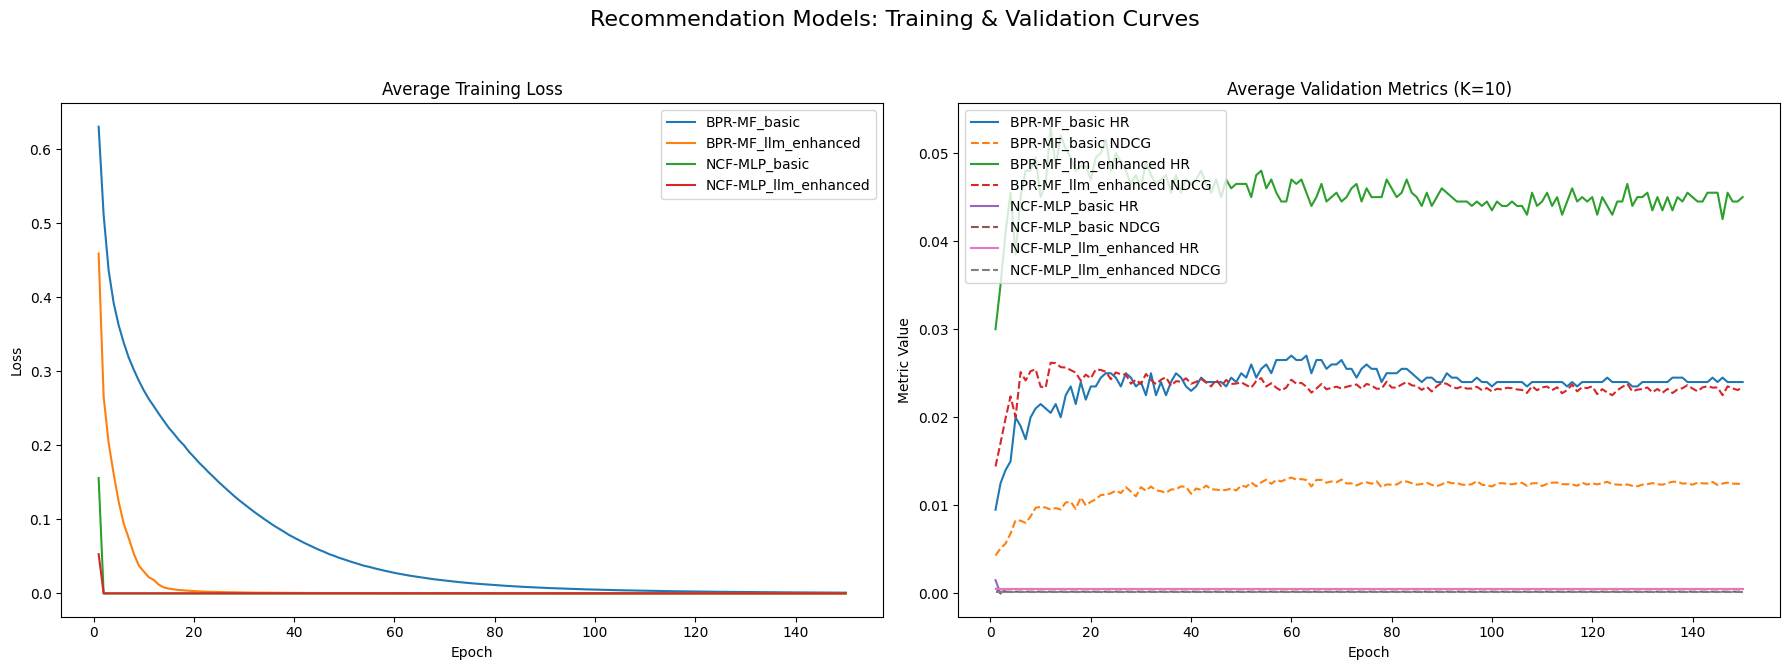

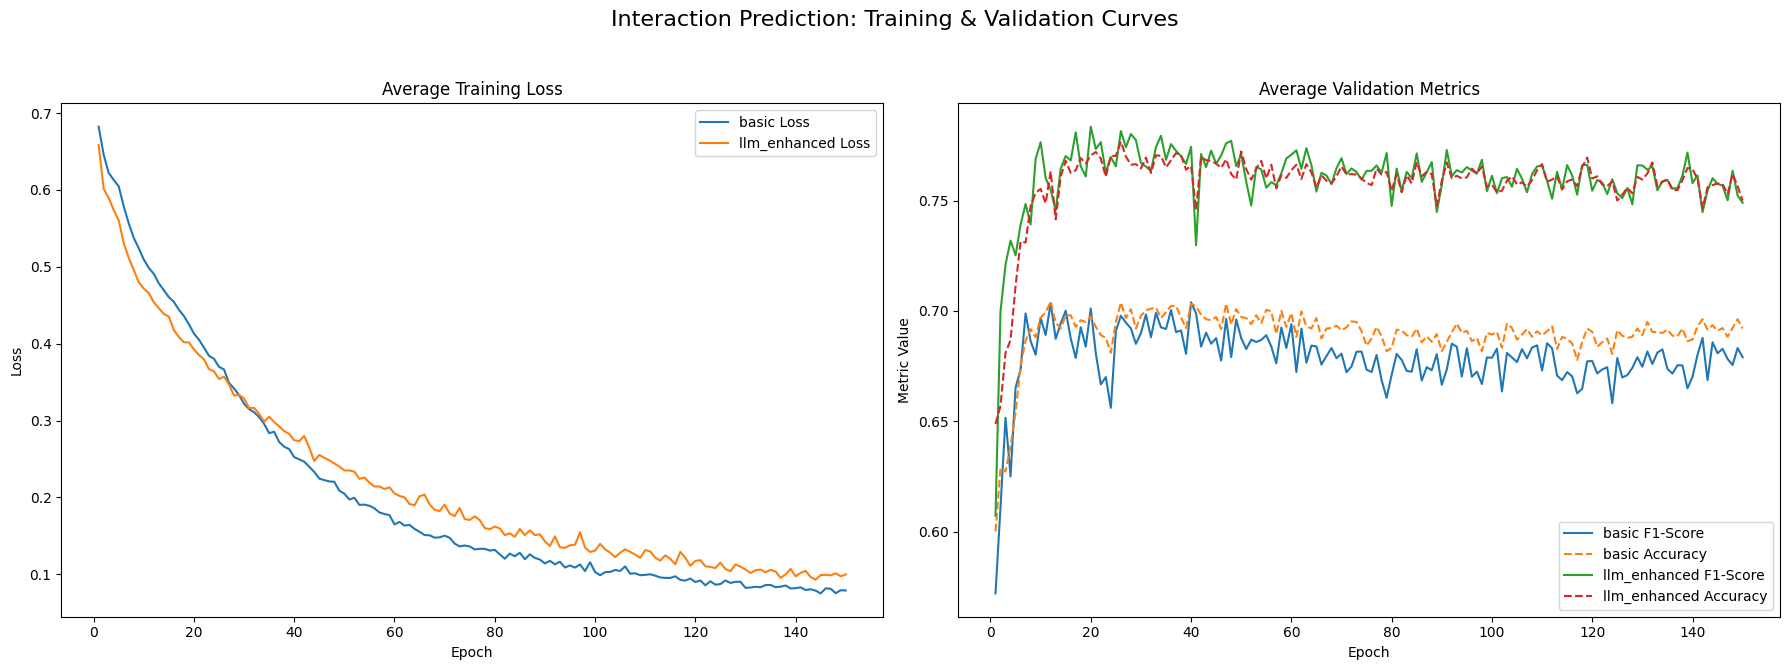

In [ ]:
if __name__ == '__main__':
    main()